In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential , load_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
import os
import shutil

# Define the path to the original dataset
data_path = '/content/gdrive/MyDrive/AICapstoneProjectData/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
# Define the path to the output directory
output_path = './dataset'

# Define the ratios for train/val/test splits
train_ratio = 0.8
test_ratio = 0.2

# Create the output directories if they do not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)
for dir_name in ['train', 'test']:
    dir_path = os.path.join(output_path, dir_name)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    for class_name in ['Cyst','Normal','Stone','Tumor']:
        class_path = os.path.join(dir_path, class_name)
        if not os.path.exists(class_path):
            os.makedirs(class_path)

# Loop over each class and copy files to train/val/test directories
for class_name in ['Cyst', 'Normal', 'Stone', 'Tumor']:
    class_path = os.path.join(data_path, class_name)
    files = os.listdir(class_path)
    num_files = len(files)
    num_train = int(num_files * train_ratio)
    num_test = num_files - num_train
    for i, file_name in enumerate(files):
        src_path = os.path.join(class_path, file_name)
        if i < num_train:
            dst_path = os.path.join(output_path, 'train', class_name, file_name)
        else:
            dst_path = os.path.join(output_path, 'test', class_name, file_name)
        shutil.copy(src_path, dst_path)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

train_path = './dataset/train'
test_path = './dataset/test'

img_size = (224,224)
batch_size = 25
test_batch_size = 32
test_steps = 1

#applying normalization and data Argumentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    preprocessing_function=preprocess_input,

)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(224,224),
    class_mode='categorical',
    shuffle=True,
    batch_size=batch_size
)

test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224,224),
    class_mode='categorical',
    shuffle=False,
    batch_size=test_batch_size
)

classes = list(train_generator.class_indices.keys())
class_count = len(classes)
train_steps = int(np.ceil(len(train_generator.labels) / batch_size))

Found 9955 images belonging to 4 classes.
Found 2492 images belonging to 4 classes.


In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

train_data = train_generator[0][0]
train_labels = train_generator[0][1]
test_data = test_generator[0][0]
test_labels = test_generator[0][1]

# Reshape the data to 2D for KNN
train_data = np.reshape(train_data, (train_data.shape[0], -1))
test_data = np.reshape(test_data, (test_data.shape[0], -1))

# Convert one-hot encoded labels to integer labels
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# Split the data into training and validation sets with a 70/30 split
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Define a range of K values to search over
k_values = [3, 5, 7, 9, 11, 13, 15, 17]

# Calculate accuracies for different values of K
train_accuracy = []
val_accuracy = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_preds = knn.predict(X_train)
    val_preds = knn.predict(X_val)
    train_accuracy_score = accuracy_score(y_train, train_preds)
    val_accuracy_score = accuracy_score(y_val, val_preds)
    train_accuracy.append(train_accuracy_score)
    val_accuracy.append(val_accuracy_score)

# Print the accuracies for different values of K
for k, train_acc, val_acc in zip(k_values, train_accuracy, val_accuracy):
    print(f"K = {k}, train accuracy = {train_acc*100}, validation accuracy = {val_acc*100}")

# Select the best K based on the validation accuracy and evaluate the model on the test data
best_k = k_values[np.argmax(val_accuracy)]
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(train_data, train_labels)
test_acc = best_knn.score(test_data, test_labels)
print(f"Best K = {best_k}, test accuracy = {test_acc}")

K = 3, train accuracy = 55.00000000000001, validation accuracy = 40.0
K = 5, train accuracy = 50.0, validation accuracy = 20.0
K = 7, train accuracy = 50.0, validation accuracy = 60.0
K = 9, train accuracy = 50.0, validation accuracy = 20.0
K = 11, train accuracy = 40.0, validation accuracy = 20.0
K = 13, train accuracy = 35.0, validation accuracy = 20.0
K = 15, train accuracy = 30.0, validation accuracy = 0.0
K = 17, train accuracy = 30.0, validation accuracy = 0.0
Best K = 7, test accuracy = 0.0


KNN using GridSearch

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import random

#set the seed value
random.seed(100)
np.random.seed(100)

# Get the training and testing data
x_train, y_train = train_generator.next()
x_test, y_test = test_generator.next()

# Reshape the data to 2D
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Normalize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Apply PCA to reduce the dimensionality of the data
pca = PCA(n_components=20)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

# Define the range of k values to consider
k_values = range(2, 11)

# Define the parameter grid for cross-validation
param_grid = {'knn__n_neighbors': k_values, 'knn__weights': ['uniform', 'distance'], 'knn__p': [2], 'knn__algorithm': ['ball_tree'], 'knn__leaf_size': [10]}

# Define the KNN model with L2 regularization
knn_model = KNeighborsClassifier(weights='uniform', algorithm='ball_tree', p=2, leaf_size=10)

# Define the pipeline with PCA and the KNN model
pipeline = Pipeline(steps=[('pca', pca), ('knn', knn_model)])

# Define the cross-validation object with stratified sampling
cv = StratifiedKFold(n_splits=5)

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(pipeline,param_grid, cv=cv, scoring='accuracy',error_score = 'raise')
grid_search.fit(x_train, np.argmax(y_train, axis=1))

# Get the best hyperparameters and the best model
best_k = grid_search.best_params_['knn__n_neighbors']
best_weights = grid_search.best_params_['knn__weights']
best_p = grid_search.best_params_['knn__p']
best_algorithm = grid_search.best_params_['knn__algorithm']
best_leaf_size = grid_search.best_params_['knn__leaf_size']
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best hyperparameters:")
print("k = {}".format(best_k))
print("weights = {}".format(best_weights))
print("p = {}".format(best_p))
print("algorithm = {}".format(best_algorithm))
print("leaf_size = {}".format(best_leaf_size))

# Fit the best model to the training data
best_model.fit(x_train, np.argmax(y_train, axis=1))

# Get the predictions for the training and testing data
train_preds = best_model.predict(x_train)
test_preds = best_model.predict(x_test)

# Calculate the accuracy of the model on the training and testing data
train_accuracy = accuracy_score(np.argmax(y_train, axis=1), train_preds)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), test_preds)

# Print the accuracy for the best model
print("Best model: Training Accuracy: {:.2f}%, Testing Accuracy: {:.2f}%".format(train_accuracy * 100, test_accuracy * 100))

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters:
k = 4
weights = uniform
p = 2
algorithm = ball_tree
leaf_size = 10
Best model: Training Accuracy: 56.00%, Testing Accuracy: 18.75%


In [ ]:
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels
y_true = np.argmax(y_test, axis=1)
y_pred = best_model.predict(x_test)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Get the accuracy for each class
class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Print the accuracy for each class
print("Accuracy for Each Class:")
for i in range(len(class_accuracy)):
    print("Class {}: {:.2f}%".format(i, class_accuracy[i] * 100))

Confusion Matrix:
[[ 6 26]
 [ 0  0]]
Accuracy for Each Class:
Class 0: 18.75%
Class 1: nan%


<ipython-input-98-9ce050cfbbcf>:15: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = cm.diagonal() / cm.sum(axis=1)


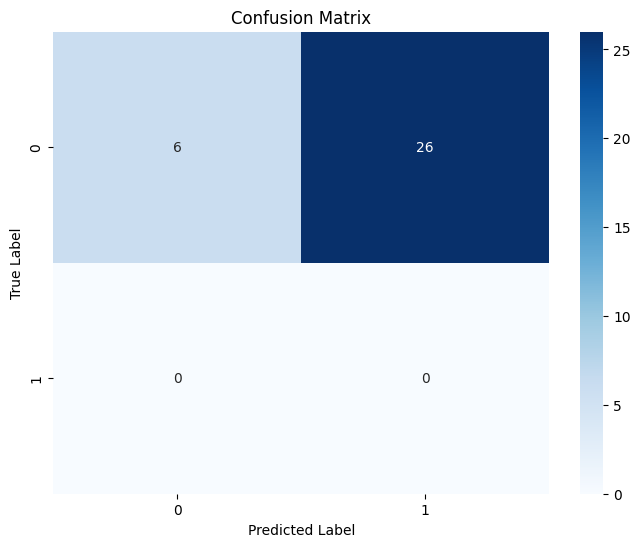

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()